In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

import sys
sys.path.append('resources')
import models

# Residuals

When building regression models of all kinds, we are often concerned with improving the model. There are many ways to do this. Many of them involve domain knowledge, did we leave any important variables out? These kinds of questions can be answered by looking at the $R^2$ or $\sigma$ (error of the regression). If the $R^2$ is low or the $\sigma$ is high, it may not be because of missing variables but because of not enough data. This is one of the advantages of many of the *machine learning* methods for evaluation models because we can thinking of our models in terms under or overfitting and see where we might be under or overfitting. We'll look at *general* model evaluation in the next chapter.

A more typical approach for linear regression, however, is to look at the *residuals*. Remember that our regression model is a linear function of the features:

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + N(0,\sigma)$

We learn this model from a set of observations, $(X, y)$. This means, for every observation, we can use the model to estimate what we think y would be ($\hat{y}$) and we have the actual $y$ to compare to. The difference is called the *residual* short for "residual error of the model$:

$r_i = y_i - \hat{y}_i$

where $i$ is some observation. If $r_i$ is positive, we underestimated $y$ and if $r_i$ is negative, we overestimated $y$. When we look at residuals, we plot them against a numerical feature that has been sorted. We should *not* see any pattern other than, essentially, $\epsilon$. Remember that $\epsilon$ is normally distributed with mean 0 and some $\sigma$.

Because the feature $x_j$ is sorted, we will readily be able to see many patterns if they exist in the data. Put a different way, we should *not* see any patterns if our model is sufficient.

What patterns might we see?

1. The distribution of residuals may not be distributed normally, $N(0, \sigma)$.
2. The residuals may increase as $x_j$ increases.
3. The residuals may decrease as $x_j$ decreases.
4. There may be some non-linear change in residuals as $x_j$ changes (high residuals at low and high values of $x_j$ but low residuals at $x_j$).

While you will often hear about the first one, this is often the least interesting of the bunch. While a large divergence from normality may affect our ability to generate accurate predictions, it does not impair our ability to study effects.

Let's look at an example.

## Noiseless Data

We're going to start with the dead simplest generated data and regression: one with $\epsilon = 0$:

$y = 1.00 + 2.5 x_1 + N(0, 0)$

Note that the *generating* function generates $y$ and not $\hat{y}$. The generating function is the real deal. We're going to estimate the following model:

$\hat{y} = \beta_0 + \beta_1 x_1 + \epsilon$

Without loss of generality, I'm going to make $x_1$ have a domain of about $(0,10)$. This makes the $\beta_0$ term "meaningful" because it can actually occur in the domain of $x_1$ and we can side step all of *those* problems.

In [4]:
np.random.seed(6734745)

In [5]:
x1 = np.array( [10*np.random.random() for _ in range( 100)])
ys = 1.00 + 2.5 * x1
data = pd.DataFrame({"y": ys, "x1": x1})

In [6]:
data.describe()

,y,x1
count,100.000000,100.000000
mean,14.361599,5.344639
std,7.921989,3.168796
min,1.238822,0.095529
25%,7.408161,2.563264
50%,14.683931,5.473572
75%,22.504152,8.601661
max,25.866052,9.946421


Let's run the regression model. We're going to use the simple one so we can concentrate on the residuals.

In [7]:
result = models.linear_regression("y ~ x1", data)
print(models.simple_describe_lr(result))

Model: y ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  1.00
x1            $\beta_1$  2.50

Metrics       Value
$\sigma$      0.00
$R^2$         1.00
------------  ---------  -----


This is unsurprising. There's no noise in the model...it's all signal. The estimates of the coefficients are nearly exact, there's infinitesimal error, and the $R^2$ is 100%. If we chart the data and the line, we see:

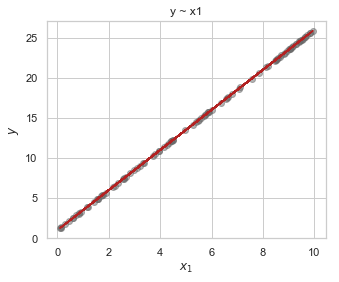

In [8]:
figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result["formula"])
axes.set_xlabel(r"$x_1$")
axes.set_ylabel(r"$y$")

plt.show()
plt.close()

We can also plot the residuals. It's often handy to calculate their mean and standard deviation as well. I'm going to limit each to 4 decimal places to avoid showing the underflow.

In [9]:
print("mean = ", "%.4f" % np.mean(result["residuals"]))
print("std  = ", "%.4f" % np.std(result["residuals"]))

mean =  -0.0000
std  =  0.0000


And here's the residual plot. Note that I had to do something similar with the y axis because of the underflow. Otherwise, you see a pattern that is entirely do to floating point error.

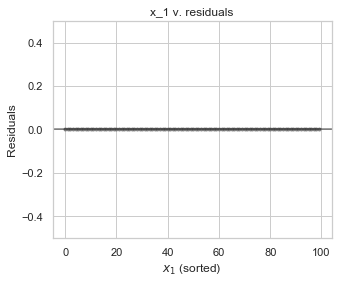

In [10]:
figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)

# sorted
keyed_values = sorted(zip( data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_ylim((-0.5, 0.5))
axes.set_ylabel("Residuals")
axes.set_xlabel(r"$x_1$ (sorted)")

plt.show()
plt.close()

There's nothing to see here but that's good. We're just setting up the remaining examples. At first we're going to concentrate on looking at patterns in data that have no "noise". We'll introduce noise at the end so that the data looks more realistic.

## A Squared Term

So far, so good. We have a perfect model and perfect residuals. What I want to do now is show you what the residuals would look like--in the absence of noise--if the true function were:

$y = 1.00 + 2.5 x_1^2 + N(0, 0)$

but we only estimated:

$\hat{y} = \beta_0 + \beta_1 x_1 + \epsilon$

First, we need the data. We'll call this new "y", "y1" and add "x1_sqrd".

In [11]:
data[ "x1_sqrd"] = data.x1 ** 2
data["y1"] = 1.00 + 2.5 * data.x1_sqrd

data.describe()

,y,x1,x1_sqrd,y1
count,100.000000,100.000000,100.000000,100.000000
mean,14.361599,5.344639,38.506023,97.265058
std,7.921989,3.168796,34.046488,85.116221
min,1.238822,0.095529,0.009126,1.022814
25%,7.408161,2.563264,6.570634,17.426584
50%,14.683931,5.473572,29.960363,75.900909
75%,22.504152,8.601661,73.989326,185.973315
max,25.866052,9.946421,98.931284,248.328209


Let's fit the model:

In [12]:
result = models.linear_regression("y1 ~ x1", data)
print(models.simple_describe_lr(result))

Model: y1 ~ x1
------------  ---------  ------
Coefficients             Value
              $\beta_0$  -42.42
x1            $\beta_1$  26.14

Metrics       Value
$\sigma$      19.75
$R^2$         0.95
------------  ---------  ------


Wait. There's no noise. Why is the $R^2$ less than 100%? And the error is now 19.7 units. Let's look at a scatter plot of the data, the model, and the residuals:

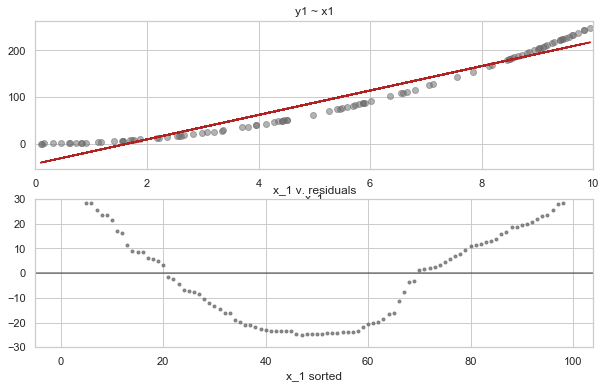

In [13]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y1, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

When plotting residuals, it's always a good idea to have a symmetric y scale. This way you can see skewed residuals more easily. If you let the automatic scaling do its thing, sometimes it will look normal-ish when it's not.

These residuals clearly have a pattern they should not have. Notice also it occurs in the absence of "noise". What we can see here is a misspecified model in its pure form. There is at least one caveat. The real data was generated by the function:

$y = 1.00 + 2.5 x_1^2 + N(0, 0)$

Notice the relationship of the coefficient 2.5 to the intercept ($\beta_0$) 1.00? What if it were smaller? Let's make it 0.025 instead of 2.5.

In [14]:
data["y1"] = 1.00 + 0.025 * data.x1_sqrd

data.describe()

,y,x1,x1_sqrd,y1
count,100.000000,100.000000,100.000000,100.000000
mean,14.361599,5.344639,38.506023,1.962651
std,7.921989,3.168796,34.046488,0.851162
min,1.238822,0.095529,0.009126,1.000228
25%,7.408161,2.563264,6.570634,1.164266
50%,14.683931,5.473572,29.960363,1.749009
75%,22.504152,8.601661,73.989326,2.849733
max,25.866052,9.946421,98.931284,3.473282


And let's estimate the model:

In [15]:
result = models.linear_regression("y1 ~ x1", data)
print(models.simple_describe_lr(result))

Model: y1 ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  0.57
x1            $\beta_1$  0.26

Metrics       Value
$\sigma$      0.20
$R^2$         0.95
------------  ---------  -----


And plot the data, model, and residuals:

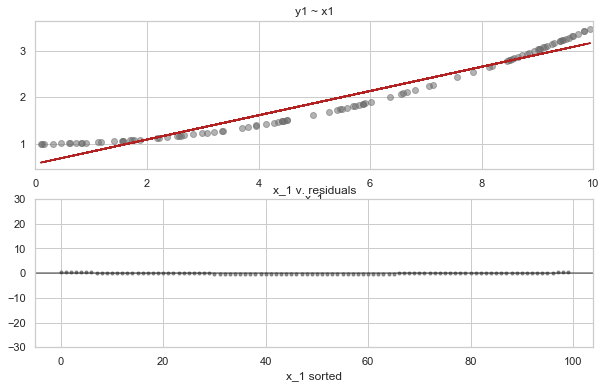

In [16]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y1, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

If we compare this with the original model, our $R^2$ is the same but the $\sigma$ is significantly smaller. Although the true data was generated by $x_1^2$, because it has such a small effect on $y$, not knowing this creates less of a problem, generates a smaller error. We'll be able to see later that such small effects can easily get swamped by larger ones elsewhere.

These experiments also emphasize the importance of working with synthetic data. The only way to really discover all the possibilities is to explore them. Working with synthetic data gives you a safety net. The fun part is when you generate data and it doesn't have the pattern you expected.

So based on the pattern in the residuals, we conclude that the real model includes a squared term. We'll see in the next section how to handle that. Let's continue with our exploration of residuals.

Let's put $y_1$ back:

## A Square Root Term

Let's look at another one. What if the true generating function is:

$y = 1.00 + 2.5 \sqrt{x_1} + N(0, 0)$

and we estimate:

$\hat{y} = 1.00 + 2.5 x_1 + \epsilon$

?

In [17]:
data["x1_sqrt"] = np.sqrt( data.x1)
data["y1"] = 1.00 + 2.5 * data.x1_sqrt

data.describe()

,y,x1,x1_sqrd,y1,x1_sqrt
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,14.361599,5.344639,38.506023,6.426707,2.170683
std,7.921989,3.168796,34.046488,1.998699,0.799480
min,1.238822,0.095529,0.009126,1.772694,0.309078
25%,7.408161,2.563264,6.570634,5.002526,1.601010
50%,14.683931,5.473572,29.960363,6.848908,2.339563
75%,22.504152,8.601661,73.989326,8.332138,2.932855
max,25.866052,9.946421,98.931284,8.884487,3.153795


Again, we don't the true generating function so we start with $x_1$:

In [18]:
result = models.linear_regression("y1 ~ x1", data)
print(models.simple_describe_lr(result))

Model: y1 ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  3.12
x1            $\beta_1$  0.62

Metrics       Value
$\sigma$      0.39
$R^2$         0.96
------------  ---------  -----


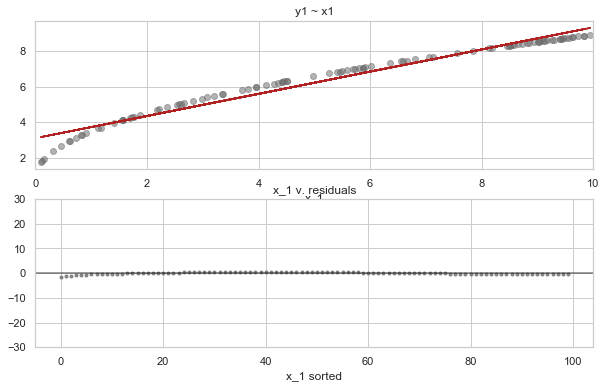

In [19]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y1, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

We have the opposite pattern.

We can go in a lot of different directions from here. For example, all of the models so far are noiseless...there are no "unknown unknowns". Additionally, $x_1$ is from a uniform distribution...and not one of the myriad other distributions that $x_i$ could be from.

## Noise

When we start thinking about generating functions for fake data, we need to think a bit about how the pieces all fit together. Oddly enough, this also allows us to interpret the various parameters ($\beta_i, \sigma$) of real models better.

Remember that coefficients ($\beta_i, i > 0$) are both the *effect* of a variable and the *scaling* or *translation* of it into the units of $y$. Consider the following model:

$y = 10.0 + 2.5 x_1 - 3.5 x_2 + 1.7 x_3 - 2.9 x_4 + N(0, 2.5)$

We can read this as starting with the value "10.0", adding 2.5 units of $y$ for each unit of $x_1$, subtracting 3.5 units of y for each unit of $x_2$, adding 1.7 units of y per unit of $x_3$ and subtracting 2.9 units of $y$ for each unit of $x_4$. Finally, we add a bit of noise to represent the "(un)known unknowns".

Where this all ends up depends on the domains of the variables $x_1$, $x_2$, $x_3$, $x_4$. We do know that if and when all the $x$'s are equal to zero, $y$ is effectively:

$y = N(10.0, 2.5)$

if you remember from the earliest module, the coefficient of variation, $v$, is $\frac{std}{mean}$ or 2.5/10 = 0.25 (25.0%). That may be a lot of noise depending on the domains of $x$. This is the key point I want you take away. These can lead to very different results. Here is the current model we've been working with using $\epsilon$ = 0.25, 2.5, 5.0 and the resulting models:

In [20]:
e = stats.norm.rvs(0, 0.25, 100)
data[ "y"] = 1.00 + 2.5 * x1 + e

data.describe()

,y,x1,x1_sqrd,y1,x1_sqrt
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,14.353545,5.344639,38.506023,6.426707,2.170683
std,7.923677,3.168796,34.046488,1.998699,0.799480
min,1.133556,0.095529,0.009126,1.772694,0.309078
25%,7.349998,2.563264,6.570634,5.002526,1.601010
50%,14.852596,5.473572,29.960363,6.848908,2.339563
75%,22.448807,8.601661,73.989326,8.332138,2.932855
max,25.367600,9.946421,98.931284,8.884487,3.153795


And, you guessed it, let's estimate the model:

In [21]:
result = models.linear_regression("y ~ x1", data)
print(models.simple_describe_lr(result))

Model: y ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  0.99
x1            $\beta_1$  2.50

Metrics       Value
$\sigma$      0.22
$R^2$         1.00
------------  ---------  -----


This isn't a lot of noise but it is some:

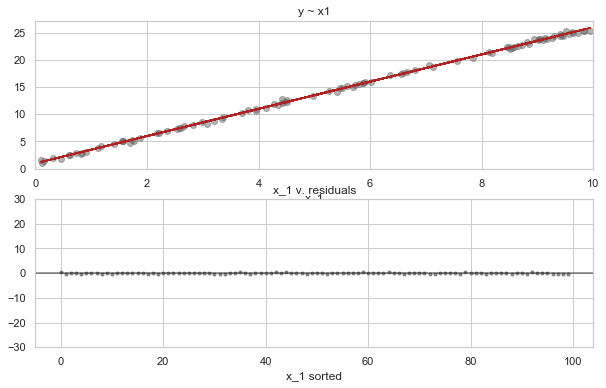

In [22]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

Let's add more noise.

In [23]:
e = stats.norm.rvs(0, 2.5, 100)
data[ "y"] = 1.00 + 2.5 * x1 + e

We'll estimate the model again:

In [24]:
result = models.linear_regression("y ~ x1", data)
print(models.simple_describe_lr(result))

Model: y ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  1.17
x1            $\beta_1$  2.40

Metrics       Value
$\sigma$      2.12
$R^2$         0.93
------------  ---------  -----


And plot the data, model, and residuals:

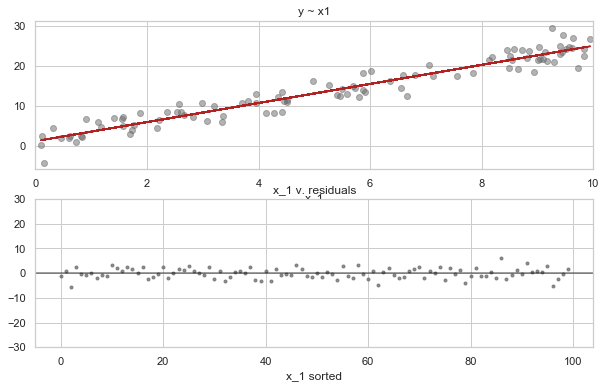

In [25]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

This is closer to the residuals we might start to see. Let's increase the noise one more time:

In [26]:
e = stats.norm.rvs(0, 10.0, 100)
data[ "y"] = 1.00 + 2.5 * x1 + e

Fit our model:

In [27]:
result = models.linear_regression("y ~ x1", data)
print(models.simple_describe_lr(result))

Model: y ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  2.63
x1            $\beta_1$  2.45

Metrics       Value
$\sigma$      10.32
$R^2$         0.36
------------  ---------  -----


And chart the data, model, and residuals:

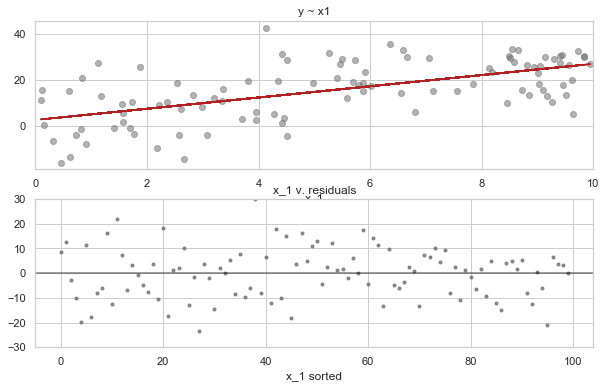

In [28]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

This looks a bit more realistic but what if we revisit one of our earlier models with a squared term? We can look all in one fell swoop.

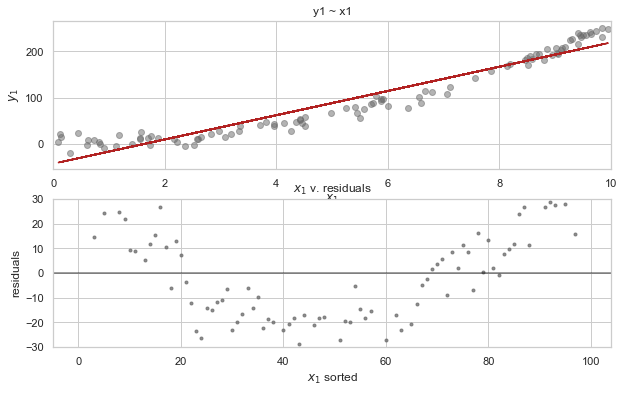

In [29]:
e = stats.norm.rvs(0, 10.0, 100)
data[ "y1"] = 1.00 + 2.5 * data.x1_sqrd + e

result = models.linear_regression("y1 ~ x1", data)
models.simple_describe_lr(result)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y1, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel(r"$x_1$")
axes.set_ylabel(r"$y_1$")
axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( r"$x_1$ v. residuals")
axes.set_xlabel( r"$x_1$ sorted")
axes.set_ylabel("residuals")
axes.set_ylim((-30.0, 30.0))

plt.show()
plt.close()

## Full Multivariate Model

You need to look at the residuals for all of your numerical variables. Let's look at the multivariate model from above:

$y = 10.0 + 2.5 x_1 - 3.5 x_2 + 1.7 x_3 - 2.9 x_4 + N(0, 5.0)$

we can we can use as a data generating model. To make things interesting, we're only going to use the first two variables, $x_1$ and $x_2$:

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon$

We'll generate the variables we need from Normal distributions:

In [30]:
data["x2"] = stats.norm.rvs(5, 0.5, 100)
data["x3"] = stats.norm.rvs(7, 0.2, 100)
data["x4"] = stats.norm.rvs(8, 0.3, 100)
data["x5"] = stats.norm.rvs(3, 0.3, 100)
data["y"] = 10.0 + 2.5 * data.x1 - 3.5 * data.x2 + 1.7 * data.x3 - 2.9 * data.x4 + stats.norm.rvs(0, 5,100)

And describe it:

In [31]:
data.describe()

,y,x1,x1_sqrd,y1,x1_sqrt,x2,x3,x4,x5
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-6.342219,5.344639,38.506023,97.683711,2.170683,5.028293,6.977789,8.074251,3.017084
std,8.379301,3.168796,34.046488,86.167871,0.799480,0.517574,0.201689,0.320094,0.325489
min,-26.411007,0.095529,0.009126,-19.351237,0.309078,3.927467,6.511310,7.109811,2.099009
25%,-12.851496,2.563264,6.570634,19.135166,1.601010,4.716104,6.834748,7.889215,2.805623
50%,-4.895713,5.473572,29.960363,77.022920,2.339563,5.020235,6.980163,8.058954,3.029154
75%,-0.553659,8.601661,73.989326,186.761802,2.932855,5.371569,7.134441,8.276449,3.232930
max,12.850611,9.946421,98.931284,250.967081,3.153795,6.151773,7.404249,8.899653,3.767994


Let's estimate the first model:

In [32]:
result = models.linear_regression("y ~ x1 + x2", data)
print(models.simple_describe_lr(result))

Model: y ~ x1 + x2
------------  ---------  -----
Coefficients             Value
              $\beta_0$  -6.10
x1            $\beta_1$  2.13
x2            $\beta_2$  -2.32

Metrics       Value
$\sigma$      4.74
$R^2$         0.69
------------  ---------  -----


The $R^2$ isn't bad but there's clearly room for improvement. We've included the obvious features. We have a few more variables we didn't include but which ones should we pick? Let's look at the residuals:

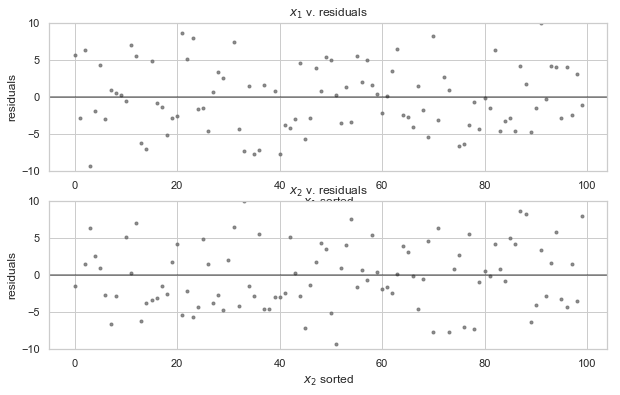

In [33]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])
residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( r"$x_1$ v. residuals")
axes.set_xlabel( r"$x_1$ sorted")
axes.set_ylabel("residuals")
axes.set_ylim((-10.0, 10.0))

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x2, result["residuals"]), key=lambda x: x[ 0])
residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( r"$x_2$ v. residuals")
axes.set_xlabel( r"$x_2$ sorted")
axes.set_ylabel("residuals")
axes.set_ylim((-10.0, 10.0))

plt.show()
plt.close()

The residuals don't show any patterns. The residuals are in a weird format, let's make them a regular array:

In [34]:
residuals = [r[0] for r in result["residuals"]]

And let's think about what residuals are. Residuals are the difference between the observed y and the estimated y, $\hat{y}$. $\hat{y}$ is based on a linear equation. If the equation were missing a term, $\beta_3 x_3$, for example, then the residuals must be missing it, too. Because the $\beta_3$ is a constant, the correlation must exist between the residuals and the variable. Does it?

In [35]:
print("x_1 = {0:.2f}".format(stats.pearsonr(residuals, data.x1)[0]))

x_1 = 0.00


We're not missing $x_1$. $x_2$?

In [36]:
print("x_2 = {0:.2f}".format(stats.pearsonr(residuals, data.x2)[0]))

x_2 = 0.00


We're not missing $x_2$ $x_3$?

In [37]:
print("x_3 = {0:.2f}".format(stats.pearsonr(residuals, data.x3)[0]))

x_3 = 0.20


We might be missing $x_3$. $x_4$?

In [38]:
print("x_4 = {0:.2f}".format(stats.pearsonr(residuals, data.x4)[0]))

x_4 = -0.08


We might be missing $x_4$. $x_5$?

In [39]:
print("x_5 = {0:.2f}".format(stats.pearsonr(residuals, data.x5)[0]))

x_5 = 0.03


I added in $x_5$ so that you could see that this is not foolproof. We know that we are not missing $x_5$. We also know that we are missing both $x_3$ and $x_4$ but the correlations with the residuals are not huge. This will depend on the noise in the data, $N(0, \sigma)$, which we cannot know.

If there is a clear domain reason for including this values, then we should do it. Of course, this is science, so we might consider if there *must* be a reason:

In [40]:
result = models.linear_regression("y ~ x1 + x2 + x3 + x4 + x5", data)
print(models.simple_describe_lr(result))

Model: y ~ x1 + x2 + x3 + x4 + x5
------------  ---------  ------
Coefficients             Value
              $\beta_0$  -32.05
x1            $\beta_1$  2.16
x2            $\beta_2$  -2.62
x3            $\beta_3$  5.09
x4            $\beta_4$  -1.26
x5            $\beta_5$  0.66

Metrics       Value
$\sigma$      4.69
$R^2$         0.70
------------  ---------  ------


These are all a bit off their true values:

$y = 10.0 + 2.5 x_1 - 3.5 x_2 + 1.7 x_3 - 2.9 x_4 + N(0, 5.0)$

versus

$\hat{y} = -32.1 + 2.2 x_1 - 2.6 x_2 + 5.1 x_3 - 1.3 x_4 + 0.66 x_5 + N(0, 4.7)$

Can the Bootstrap help?

In [41]:
result = models.bootstrap_linear_regression("y ~ x1 + x2 + x3 + x4 + x5", data)
print(models.describe_bootstrap_lr(result))

Model: y ~ x1 + x2 + x3 + x4 + x5
------------  ---------  ------  -------  -----
                                 95% BCI
Coefficients             Mean    Lo       Hi
              $\beta_0$  -32.05  -75.57   13.23
x1            $\beta_1$  2.16    1.89     2.53
x2            $\beta_2$  -2.62   -5.11    -0.59
x3            $\beta_3$  5.09    1.06     11.37
x4            $\beta_4$  -1.26   -5.17    1.59
x5            $\beta_5$  0.66    -2.89    3.54

Metrics       Mean       Lo      Hi
$\sigma$      4.69       3.83    5.03
$R^2$         0.70       0.64    0.81
------------  ---------  ------  -------  -----


If we follow the advice from the previous section, all the coefficients have their expected signs except $\beta_5$ which we should remove. $x_4$ is a bit dodgey but we're assuming that "omniscience" wins out in this case. Still, it's interesting to see if you don't have strong domain knowledge for including a variable in the model, estimation alone may not give you a reason to keep it in.

In [42]:
result = models.bootstrap_linear_regression("y ~ x1 + x2 + x3 + x4", data)
print(models.describe_bootstrap_lr(result))

Model: y ~ x1 + x2 + x3 + x4
------------  ---------  ------  -------  -----
                                 95% BCI
Coefficients             Mean    Lo       Hi
              $\beta_0$  -28.51  -79.89   10.44
x1            $\beta_1$  2.16    1.84     2.52
x2            $\beta_2$  -2.60   -4.82    -0.78
x3            $\beta_3$  4.95    0.92     9.89
x4            $\beta_4$  -1.34   -5.23    1.80

Metrics       Mean       Lo      Hi
$\sigma$      4.67       3.86    5.02
$R^2$         0.70       0.64    0.80
------------  ---------  ------  -------  -----


It isn't perfect but it is closer. We *know* that $x_4$ is in the actual data but we can't seem to recover that. Perhaps the effect is too small relative to the noise or we need more data (try to simulate getting more data). We would, of course, look at the residuals again.

## Unequal Variance

One of the assumptions for linear regression is that the noise has an equal variance. If you happen to have unequal variance, it looks something like this:

In [43]:
data["e"] = data.x1.apply(lambda x: stats.norm.rvs(0, 0.5 * x, 1)[0])
data["y1"] = 10.0 + 2.5 * data.x1 + data.e
data.describe()

,y,x1,x1_sqrd,y1,x1_sqrt,x2,x3,x4,x5,e
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-6.342219,5.344639,38.506023,23.478040,2.170683,5.028293,6.977789,8.074251,3.017084,0.116441
std,8.379301,3.168796,34.046488,8.525640,0.799480,0.517574,0.201689,0.320094,0.325489,2.604933
min,-26.411007,0.095529,0.009126,10.291584,0.309078,3.927467,6.511310,7.109811,2.099009,-5.807186
25%,-12.851496,2.563264,6.570634,15.942443,1.601010,4.716104,6.834748,7.889215,2.805623,-1.406709
50%,-4.895713,5.473572,29.960363,22.624271,2.339563,5.020235,6.980163,8.058954,3.029154,-0.066891
75%,-0.553659,8.601661,73.989326,30.726388,2.932855,5.371569,7.134441,8.276449,3.232930,1.476717
max,12.850611,9.946421,98.931284,41.381870,3.153795,6.151773,7.404249,8.899653,3.767994,9.371082


This data doesn't look much different than any of the other synthetic data we've created before except that I've done something a little sneaky. If you look at the calculation of $e$, I've made the $sigma$ a function of $x_1$. Let's see what this does:

In [44]:
result = models.linear_regression("y1 ~ x1", data)
print(models.simple_describe_lr(result))

Model: y1 ~ x1
------------  ---------  -----
Coefficients             Value
              $\beta_0$  9.78
x1            $\beta_1$  2.56

Metrics       Value
$\sigma$      2.61
$R^2$         0.91
------------  ---------  -----


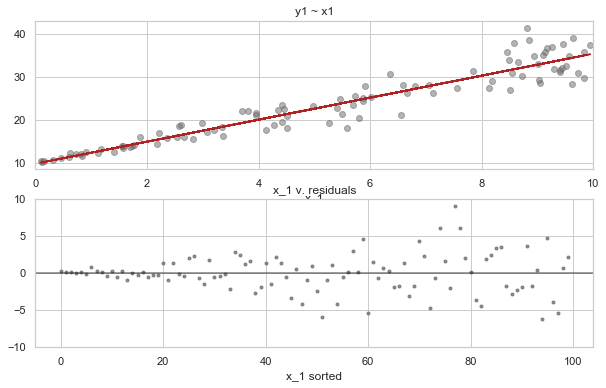

In [45]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y1, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-10.0, 10.0))

plt.show()
plt.close()

Notice that the residuals get larger as $x_1$ gets larger. This violates the assumption of equal variance. This doesn't generally affect the estimation of the coefficients but it can affect the overall performance of the model. This is just something to be aware of.

It's worth noting that EDA will often uncover many of these relationships before you even get to look at residuals.